In [1]:
!pip install transformers
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [3]:
import pandas as pd
import os
import json
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers.data.processors.utils import InputExample

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_excel('/content/drive/MyDrive/updatedcyberbulling-bangla-dataset-same-as-bangla-online-comments-dataset.xlsx')
raw_data = df.copy()
raw_data.head()

,comment,Category,Gender,comment react number,label,binary label
0,আওয়ামী লীগ স্বৈরাচারী সরকার যতো দিন ক্ষমতায় থা...,Politician,male,1.0,religious,1
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,Singer,Male,2.0,not bully,0
2,"অরে বাবা, এই টা কোন পাগল????",Actor,Female,2.0,not bully,0
3,১লক্ষ ৬হাজার মামলা নিয়ে ৩৬ লক্ষ নেতা কর্মীরা ১...,Politician,Male,1.0,not bully,0
4,যানবাহন বন্ধ করার পরও যদি এরকম সমাবেশের লোক হয...,Politician,Male,3.0,troll,1


In [6]:
#Dropping null values
raw_data.dropna(inplace=True)

In [7]:
raw_data.shape

(43998, 6)

In [8]:
#Dropping unnecessary columns
df = raw_data.drop(['Category','Gender','comment react number','binary label'], axis=1)
display(df)

,comment,label
0,আওয়ামী লীগ স্বৈরাচারী সরকার যতো দিন ক্ষমতায় থা...,religious
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully
2,"অরে বাবা, এই টা কোন পাগল????",not bully
3,১লক্ষ ৬হাজার মামলা নিয়ে ৩৬ লক্ষ নেতা কর্মীরা ১...,not bully
4,যানবাহন বন্ধ করার পরও যদি এরকম সমাবেশের লোক হয...,troll
...,...,...
43996,"হিরো আলম,, এগিয়ে যাও",not bully
43997,হিরো আলমকে সাপোর্ট দেওয়ার জন্য অসংখ্য ধন্যবাদ...,not bully
43998,হিরো ভাই তুমি এগিয়ে য়াও,not bully
43999,হুম ভাও তোমরা এগিয়ে যাও আমরা তোমাদের পিছনে আছি,not bully


In [9]:
# Rename the column
df.rename(columns={'comment': 'Text'}, inplace=True)

In [10]:
# Rename the column
df.rename(columns={'label': 'Result'}, inplace=True)

In [11]:
df.head()

,Text,Result
0,আওয়ামী লীগ স্বৈরাচারী সরকার যতো দিন ক্ষমতায় থা...,religious
1,ঘরে বসে শুট করতে কেমন লেগেছে? ক্যামেরাতে কে ছি...,not bully
2,"অরে বাবা, এই টা কোন পাগল????",not bully
3,১লক্ষ ৬হাজার মামলা নিয়ে ৩৬ লক্ষ নেতা কর্মীরা ১...,not bully
4,যানবাহন বন্ধ করার পরও যদি এরকম সমাবেশের লোক হয...,troll


In [12]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,Text,Result
34255,সেই লুকিন,not bully
21325,সাফা কবির এর জন্য সামান্য কিছু উপহার। লাথি+জ...,threat
29127,"সূরা আল বাকারা (البقرة), আয়াত: ৫أُو۟لَٰٓئِكَ ع...",religious
42681,যারা ইংলিশে দূর্বল তারা আমাদের এই পেইজে ঘুরে আ...,not bully
17968,তুই জারজ সন্তান,sexual
40631,যাজাকাল্লহু খাইরান।আল্লাহ আপনাকে উত্তম বিনিময় ...,not bully
13994,যেতো শাওয়ার চেহারা তার নাম আবার পেয়ারা,troll
11236,"ভবিষ্যত পরিকল্পনা করে দিয়েছি, তা ধরেই দেশ এগি...",not bully
23209,"সমালোচনা তারাই করে, যাদের কিছু করার মতো যোগ‍্য...",sexual
21250,"তোদের মানুষ এখন হিজলা বলে বেটা, দেশে আসো সাহস ...",threat


In [13]:
def sentiment2label(sentiment):
    if sentiment == "not bully":
        return 0
    else :
        return 1

df['Result'] = df['Result'].apply(sentiment2label)

In [14]:
df.head()

,Text,Result
34255,সেই লুকিন,0
21325,সাফা কবির এর জন্য সামান্য কিছু উপহার। লাথি+জ...,1
29127,"সূরা আল বাকারা (البقرة), আয়াত: ৫أُو۟لَٰٓئِكَ ع...",1
42681,যারা ইংলিশে দূর্বল তারা আমাদের এই পেইজে ঘুরে আ...,0
17968,তুই জারজ সন্তান,1


In [15]:
df_new=pd.read_csv('/content/drive/MyDrive/translation.csv')
df_new

,Text,Result
0,ড্রেকের মন ঠিক করতে হবে যে সে র্যাপার না কুত্তা?,1
1,রেডমন্ড গ্রিন কুত্তার বাচ্চা,1
2,এক দিন আগে এটা ফেলে দিন নিগ্রোদের এটা শোনা দর...,1
3,নির্বোধ গর্দভ গর্দভ,1
4,ঈগল হচ্ছে যৌনসঙ্গম বিড়াল।,1
...,...,...
9995,যদি তুই কুত্তার বাচ্চা হয়ে যাস......তাহলে আম...,1
9996,বোবা কুত্তা,1
9997,আমার হোপ পর্ব শেষ,1
9998,যে তোমাকে পছন্দ করে না তার কাছে তুমি সবসময় ক...,1


In [16]:
# Define a function to categorize cyberbullying result into two groups
df_new.loc[:,'Result']  = df_new['Result'].apply(lambda x: 1 if x != 2 else 0)
df_new.head(-10)

,Text,Result
0,ড্রেকের মন ঠিক করতে হবে যে সে র্যাপার না কুত্তা?,1
1,রেডমন্ড গ্রিন কুত্তার বাচ্চা,1
2,এক দিন আগে এটা ফেলে দিন নিগ্রোদের এটা শোনা দর...,1
3,নির্বোধ গর্দভ গর্দভ,1
4,ঈগল হচ্ছে যৌনসঙ্গম বিড়াল।,1
...,...,...
9985,"এভাবেই তুমি পুসি খাও,আমার পরে আবার করো।",1
9986,এই সব মেয়েরা বলছে যে কেউ তাদের সহ্য করতে পার...,1
9987,; এই কুত্তার মাংস বিক্রি চিকেন উইংস এবং ফ্রাই,1
9988,; পরবর্তী যে ব্যক্তিকে আমি দেখতে পাচ্ছি যে সে...,1


In [17]:
df_new['Result'].value_counts()

1    8326
0    1674
Name: Result, dtype: int64

In [18]:
df2 = pd.concat([df, df_new], axis=0)
df2

,Text,Result
34255,সেই লুকিন,0
21325,সাফা কবির এর জন্য সামান্য কিছু উপহার। লাথি+জ...,1
29127,"সূরা আল বাকারা (البقرة), আয়াত: ৫أُو۟لَٰٓئِكَ ع...",1
42681,যারা ইংলিশে দূর্বল তারা আমাদের এই পেইজে ঘুরে আ...,0
17968,তুই জারজ সন্তান,1
...,...,...
9995,যদি তুই কুত্তার বাচ্চা হয়ে যাস......তাহলে আম...,1
9996,বোবা কুত্তা,1
9997,আমার হোপ পর্ব শেষ,1
9998,যে তোমাকে পছন্দ করে না তার কাছে তুমি সবসময় ক...,1


In [19]:
df = None
df = df2
df

,Text,Result
34255,সেই লুকিন,0
21325,সাফা কবির এর জন্য সামান্য কিছু উপহার। লাথি+জ...,1
29127,"সূরা আল বাকারা (البقرة), আয়াত: ৫أُو۟لَٰٓئِكَ ع...",1
42681,যারা ইংলিশে দূর্বল তারা আমাদের এই পেইজে ঘুরে আ...,0
17968,তুই জারজ সন্তান,1
...,...,...
9995,যদি তুই কুত্তার বাচ্চা হয়ে যাস......তাহলে আম...,1
9996,বোবা কুত্তা,1
9997,আমার হোপ পর্ব শেষ,1
9998,যে তোমাকে পছন্দ করে না তার কাছে তুমি সবসময় ক...,1


In [20]:
df['Result'].value_counts()

1    36985
0    17013
Name: Result, dtype: int64

In [21]:
data_path = "/content/drive/MyDrive"
output_path = "/content/drive/MyDrive"

In [22]:
# Function to remove symbols using string operations
def remove_symbols(text):
    # Define a string containing symbols to remove
    symbols = '''[\\]^_`{|}~→'''
    return ''.join(char for char in text if char not in symbols)

# Apply the function to the 'text' column
df['Text'] = df['Text'].apply(remove_symbols)

In [23]:
df.head()

,Text,Result
34255,সেই লুকিন,0
21325,সাফা কবির এর জন্য সামান্য কিছু উপহার। লাথি+জ...,1
29127,"সূরা আল বাকারা (البقرة), আয়াত: ৫أُو۟لَٰٓئِكَ ع...",1
42681,যারা ইংলিশে দূর্বল তারা আমাদের এই পেইজে ঘুরে আ...,0
17968,তুই জারজ সন্তান,1


In [24]:
from imblearn.over_sampling import RandomOverSampler

# Separate the comments and labels
X = df['Text']
y = df['Result']

# Instantiate and apply RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y) #values.reshape helps to keep the values to a separate column. not to interfere

# Create a new DataFrame with the oversampled data
balanced_data = pd.DataFrame({'Text': X_resampled.flatten(), 'Result': y_resampled})

In [25]:
df = balanced_data

###IndicBERT

In [26]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [27]:
!pip install transformers sentencepiece

In [28]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

In [29]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [30]:
df['Result'].value_counts()

0    36985
1    36985
Name: Result, dtype: int64

In [31]:
#tf = df.tail(100)

In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [33]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df, test_size=0.3, random_state=32,stratify= df['Result'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=32,stratify=df_test['Result'])
df_train_raw.shape, df_val.shape, df_test.shape

((51779, 2), (11095, 2), (11096, 2))

In [34]:
# Get the lists of sentences and their labels.

train_sentences = df_train_raw['Text'].values
train_labels = df_train_raw['Result'].values

In [35]:
class_names = np.array(['not bully', 'bully'], dtype='<U9')
class_names

array(['not bully', 'bully'], dtype='<U9')

In [36]:
df_val['Result'] = LabelEncoder().fit_transform(df_val['Result'])
df_val.head()

,Text,Result
28442,এই মহিলাকে সবাই জুতা পিটা কর।নাস্তিকের বাচ্চা,1
55981,আমার টাকা এত পরিমান টাকা নাই। আমার বিড করার টা...,0
71939,আফসোস পোষ্টটা সে আল্লাহকে ভয় করে দেয়নি..দিয়েছে...,0
41045,অনেকে প্রিয়া সাহার নালিশ কে যুক্তি সংগত প্রমাণ...,1
26533,এটা১০০% সাইদি’র কন্ঠ না। যে এই ভূয়া পোস্টটি কর...,1


In [37]:
val_sentences = df_val['Text'].values
val_labels = df_val['Result'].values

In [38]:
# Get the lists of sentences and their labels.
test_sentences = df_test['Text'].values
test_labels = df_test['Result'].values

In [39]:
#compute the class weights
class_wts = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    )
print(class_wts)

[0.99998069 1.00001931]


In [40]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [41]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)

In [43]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)

In [44]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
#   ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

In [45]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

In [46]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)

In [47]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

In [48]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

In [49]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

In [50]:
model_name = 'ai4bharat/indic-bert'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

Loading ai4bharat/indic-bert tokenizer...


In [51]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

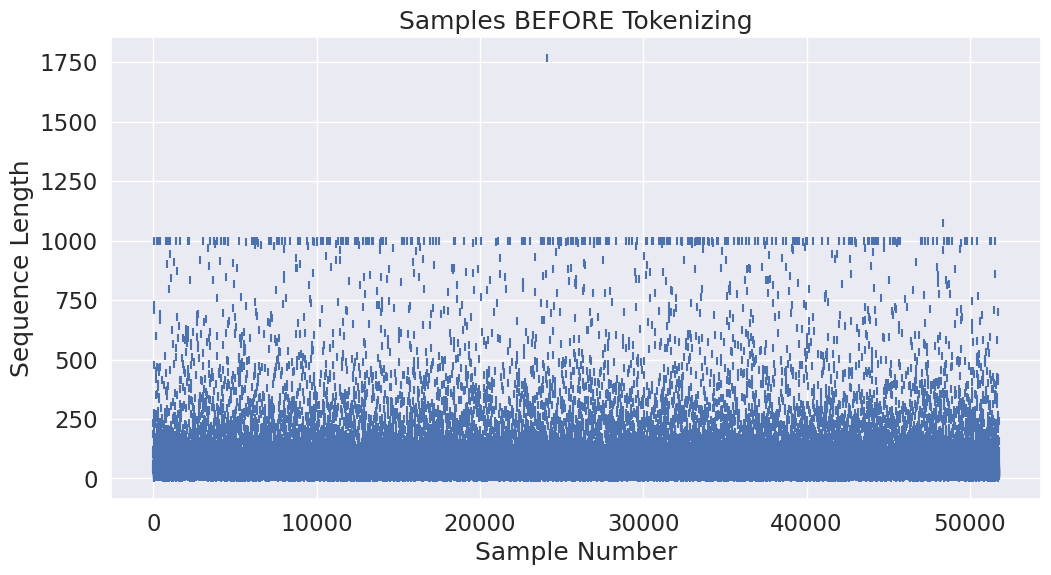

In [52]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

In [53]:
max_input_length = 260

In [54]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 51,779 training samples...
  Tokenized 0 samples.
  Tokenized 5,000 samples.
  Tokenized 10,000 samples.
  Tokenized 15,000 samples.
  Tokenized 20,000 samples.
  Tokenized 25,000 samples.
  Tokenized 30,000 samples.
  Tokenized 35,000 samples.
  Tokenized 40,000 samples.
  Tokenized 45,000 samples.
  Tokenized 50,000 samples.
DONE.
    51,779 samples


In [55]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

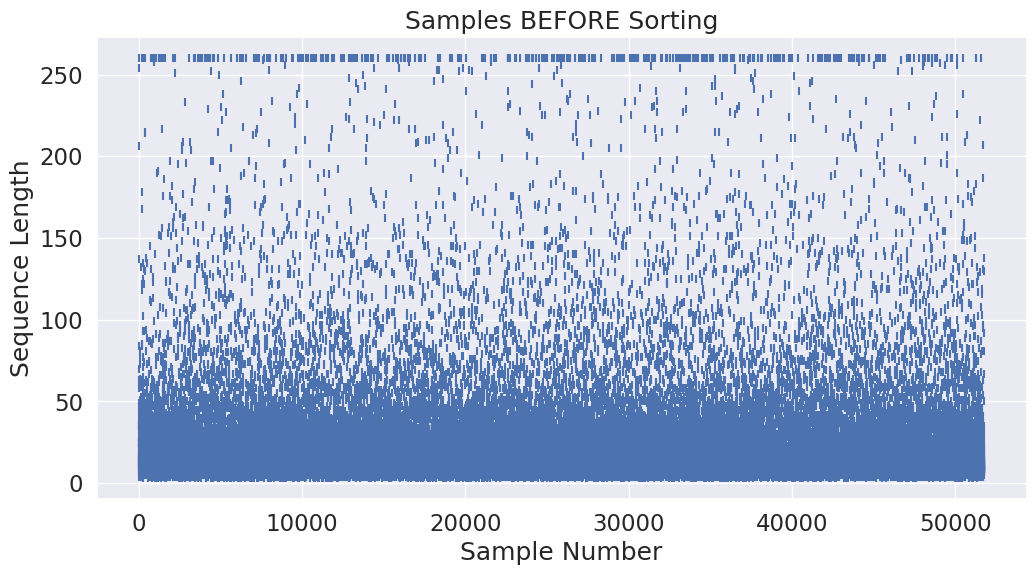

In [56]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [57]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [58]:
train_samples[0:5]

[([2, 34551, 3], 0),
 ([2, 23422, 3], 0),
 ([2, 8384, 3], 0),
 ([2, 23422, 3], 0),
 ([2, 133148, 3], 0)]

In [59]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 260


In [60]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

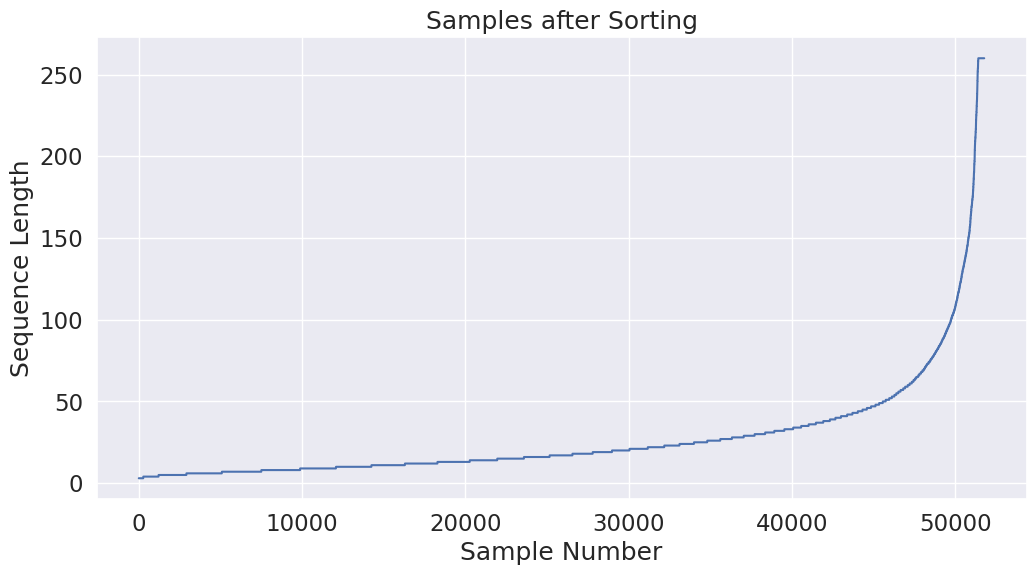

In [61]:
plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()


In [62]:
train_samples[0]

([2, 34551, 3], 0)

In [63]:
batch_size = 16

In [64]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.
  Selected 500 batches.
  Selected 600 batches.
  Selected 700 batches.
  Selected 800 batches.
  Selected 900 batches.
  Selected 1,000 batches.
  Selected 1,100 batches.
  Selected 1,200 batches.
  Selected 1,300 batches.
  Selected 1,400 batches.
  Selected 1,500 batches.
  Selected 1,600 batches.
  Selected 1,700 batches.
  Selected 1,800 batches.
  Selected 1,900 batches.
  Selected 2,000 batches.
  Selected 2,100 batches.
  Selected 2,200 batches.
  Selected 2,300 batches.
  Selected 2,400 batches.
  Selected 2,500 batches.
  Selected 2,600 batches.
  Selected 2,700 batches.
  Selected 2,800 batches.
  Selected 2,900 batches.
  Selected 3,000 batches.
  Selected 3,100 batches.
  Selected 3,200 batches.

  DONE - 3,237 batches.


In [65]:
print(batch_ordered_sentences[0])

[[2, 22605, 15292, 3071, 293, 118, 782, 69257, 118, 1747, 103064, 95923, 98, 136635, 118, 1747, 3487, 69084, 118, 1747, 8, 86626, 4306, 326, 17242, 167917, 6329, 54, 24939, 141147, 90477, 870, 81337, 1435, 30701, 46793, 3], [2, 588, 1237, 2440, 25959, 10420, 24521, 308, 26550, 1509, 3138, 6864, 109, 304, 8821, 40, 13254, 308, 1649, 1177, 463, 486, 16978, 1509, 545, 98447, 2532, 105, 636, 40, 15394, 195457, 12860, 1177, 463, 15, 3], [2, 802, 10591, 193524, 162303, 101440, 1175, 104837, 152, 15, 15, 15, 15, 15, 15, 15, 29677, 6, 162173, 88, 19508, 152, 72329, 13750, 19508, 6396, 133, 10591, 193524, 162303, 1725, 2588, 18371, 22386, 209, 7328, 3], [2, 497, 9972, 304, 369, 137521, 24016, 105, 545, 369, 7791, 160921, 1725, 369, 137521, 24016, 105, 15, 26218, 2440, 25959, 779, 978, 109, 963, 78252, 15, 58692, 145957, 109, 963, 78252, 586, 66246, 3192, 15, 3], [2, 177336, 13818, 4576, 1361, 2739, 1424, 538, 27856, 24016, 144369, 3450, 5418, 4144, 20899, 132804, 6546, 25959, 1698, 58277, 78363

In [66]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))

In [67]:
padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))

Total tokens:
   Fixed Padding: 13,462,540
  Smart Batching: 1,458,739  (89.2% less)


In [68]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=len(class_names))

print('Config type:', str(type(config)), '\n')

Config type: <class 'transformers.models.albert.configuration_albert.AlbertConfig'> 



In [69]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
model.cuda()

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768

In [71]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [72]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [73]:
# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = {
    'epoch':[],
    'train_loss':[],
    'Training Time':[],
    'val_loss':[],
    'Validation Time':[],
    'train_acc':[],
    'val_acc':[]
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()
best_accuracy = 0
# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)

    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = output.loss
        logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)

    training_accuracy = check_accuracy(predictions,true_labels)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training Accuracy: {0:.2f}".format(training_accuracy))
    print("  Training epoch took: {:}".format(training_time))

    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)
    val_loss,val_accuracy,validation_time = eval_model(model,py_inputs, py_attn_masks, py_labels)

    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_accuracy
    # Record all statistics from this epoch.

    print("")
    print("  Average validation loss: {0:.2f}".format(val_loss))
    print("  Validation Accuracy: {0:.2f}".format(val_accuracy))
    print("  Validation epoch took: {:}".format(validation_time))


    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print(f'Best val accuracy: {best_accuracy}')

model.load_state_dict(torch.load('best_model_state.bin'))

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 3,237 batches...
  Batch     300  of    3,237.    Elapsed: 0:00:27.  Remaining: 0:04:26
  Batch     600  of    3,237.    Elapsed: 0:00:51.  Remaining: 0:03:44
  Batch     900  of    3,237.    Elapsed: 0:01:17.  Remaining: 0:03:21
  Batch   1,200  of    3,237.    Elapsed: 0:01:44.  Remaining: 0:02:57
  Batch   1,500  of    3,237.    Elapsed: 0:02:12.  Remaining: 0:02:33
  Batch   1,800  of    3,237.    Elapsed: 0:02:39.  Remaining: 0:02:07
  Batch   2,100  of    3,237.    Elapsed: 0:03:05.  Remaining: 0:01:40
  Batch   2,400  of    3,237.    Elapsed: 0:03:31.  Remaining: 0:01:14
  Batch   2,700  of    3,237.    Elapsed: 0:03:58.  Remaining: 0:00:47
  Batch   3,000  of    3,237.    Elapsed: 0:04:24.  Remaining: 0:00:21

  Average training loss: 0.35
  Training Accuracy: 0.85
  Training epoch took: 0:04:46
Creating Smart Batches from 11,095 examples with batch size 16...

Tokenizing 11,095 samples...
  Tokenized 0 samples.
  Tokenized 1,000 sampl

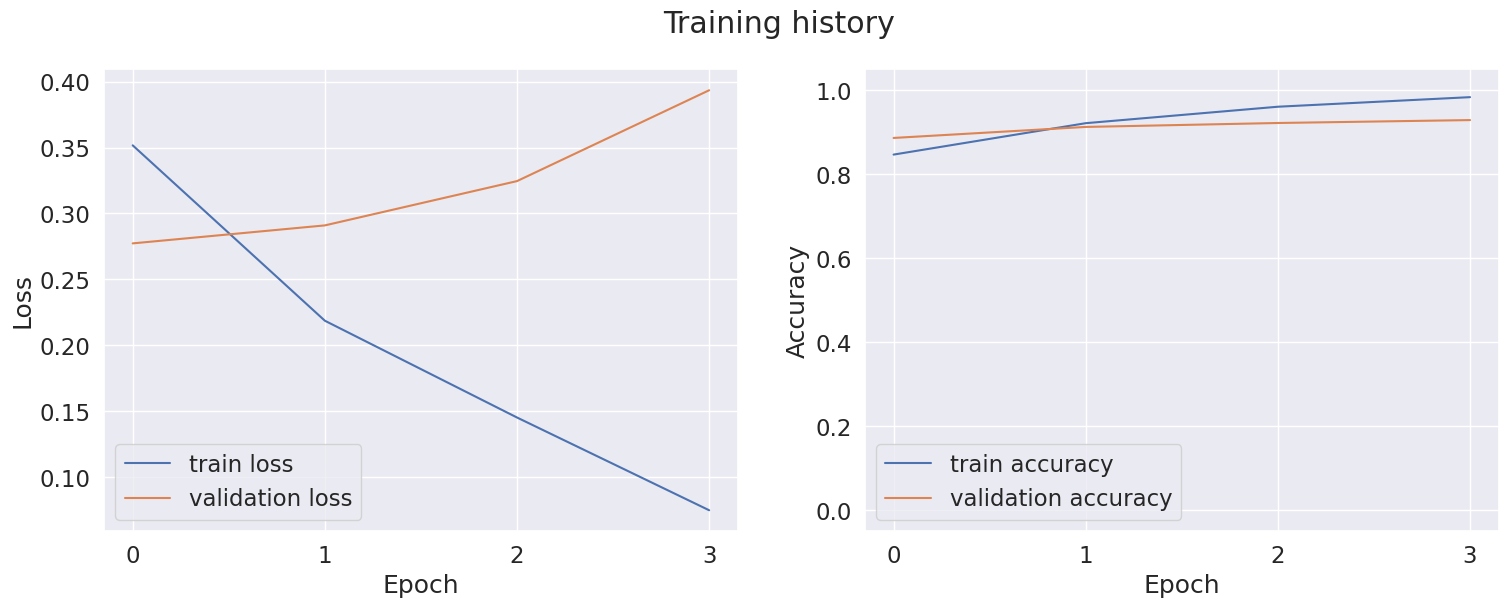

In [74]:
plot_training_history(training_stats)

In [75]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 51,779 examples with batch size 16...

Tokenizing 51,779 samples...
  Tokenized 0 samples.
  Tokenized 5,000 samples.
  Tokenized 10,000 samples.
  Tokenized 15,000 samples.
  Tokenized 20,000 samples.
  Tokenized 25,000 samples.
  Tokenized 30,000 samples.
  Tokenized 35,000 samples.
  Tokenized 40,000 samples.
  Tokenized 45,000 samples.
  Tokenized 50,000 samples.
DONE.
    51,779 samples

    51,779 samples after sorting

Creating batches of size 16...

  DONE - Selected 3,237 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 3,237 test batches...
  Batch     300  of    3,237.    Elapsed: 0:00:09.  Remaining: 0:01:25
  Batch     600  of    3,237.    Elapsed: 0:00:16.  Remaining: 0:01:11
  Batch     900  of    3,237.    Elapsed: 0:00:25.  Remaining: 0:01:04
  Batch   1,200  of    3,237.    Elapsed: 0:00:33.  Remaining: 0:00:56
  Batch   1,500  of    3,237.    Elapsed: 0:00:41.  Remaining: 0:00:47
  Batch   1,800  of    3,2

In [76]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   not bully       0.99      0.99      0.99     25890
       bully       0.99      0.99      0.99     25889

    accuracy                           0.99     51779
   macro avg       0.99      0.99      0.99     51779
weighted avg       0.99      0.99      0.99     51779



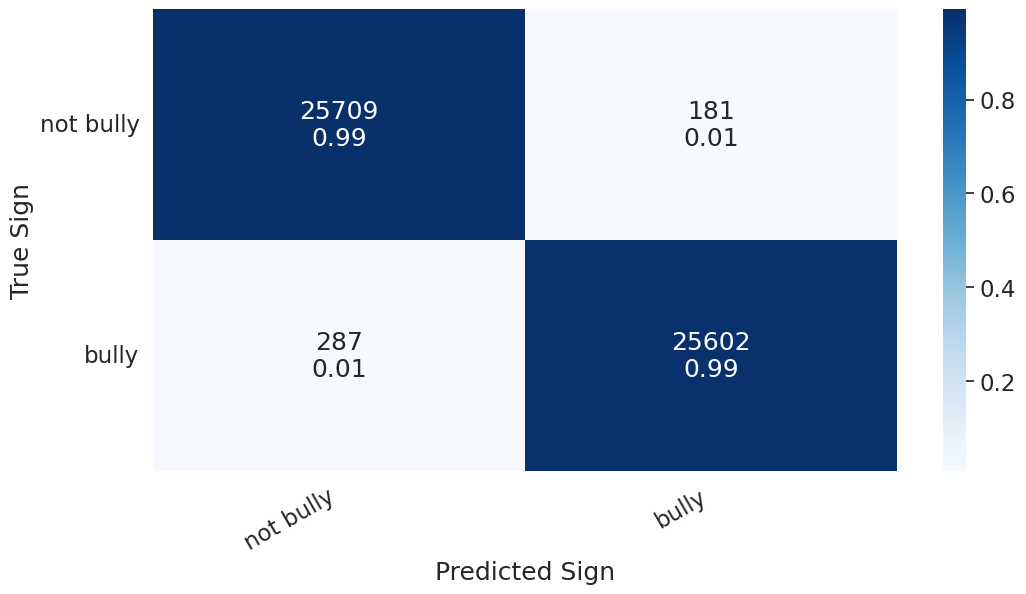

In [77]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

In [78]:

(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 11,095 examples with batch size 16...

Tokenizing 11,095 samples...
  Tokenized 0 samples.
  Tokenized 1,000 samples.
  Tokenized 2,000 samples.
  Tokenized 3,000 samples.
  Tokenized 4,000 samples.
  Tokenized 5,000 samples.
  Tokenized 6,000 samples.
  Tokenized 7,000 samples.
  Tokenized 8,000 samples.
  Tokenized 9,000 samples.
  Tokenized 10,000 samples.
  Tokenized 11,000 samples.
DONE.
    11,095 samples

    11,095 samples after sorting

Creating batches of size 16...

  DONE - Selected 694 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 694 test batches...
  Batch      70  of      694.    Elapsed: 0:00:02.  Remaining: 0:00:18
  Batch     140  of      694.    Elapsed: 0:00:04.  Remaining: 0:00:17
  Batch     210  of      694.    Elapsed: 0:00:06.  Remaining: 0:00:14
  Batch     280  of      694.    Elapsed: 0:00:08.  Remaining: 0:00:12
  Batch     350  of      694.    Elapsed: 0:00:10.  Remaining: 0:00:09
  Batch   

In [79]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   not bully       0.92      0.94      0.93      5547
       bully       0.94      0.92      0.93      5548

    accuracy                           0.93     11095
   macro avg       0.93      0.93      0.93     11095
weighted avg       0.93      0.93      0.93     11095



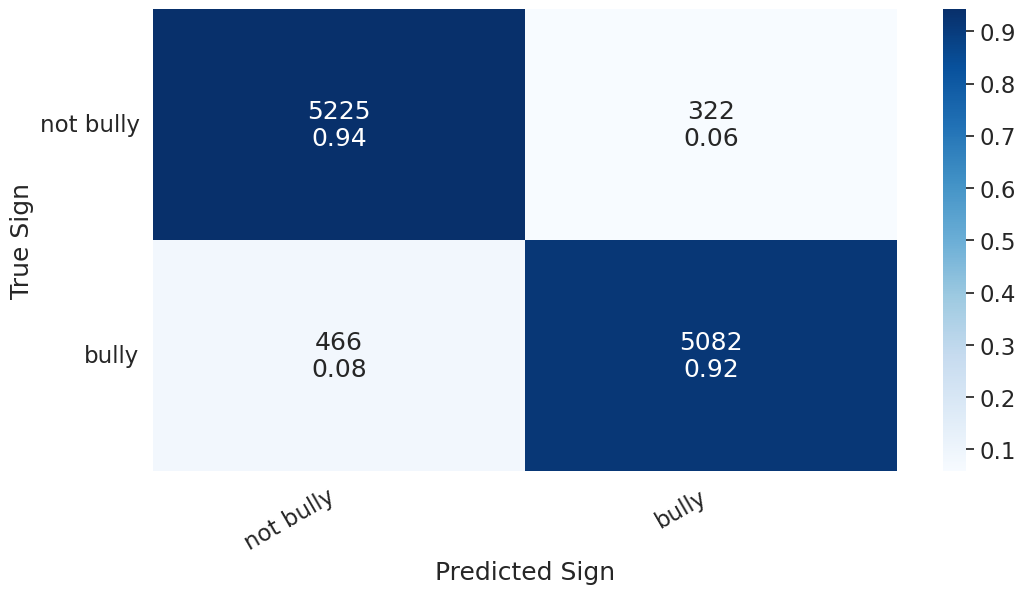

In [80]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

In [81]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(test_sentences, test_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 11,096 examples with batch size 16...

Tokenizing 11,096 samples...
  Tokenized 0 samples.
  Tokenized 1,000 samples.
  Tokenized 2,000 samples.
  Tokenized 3,000 samples.
  Tokenized 4,000 samples.
  Tokenized 5,000 samples.
  Tokenized 6,000 samples.
  Tokenized 7,000 samples.
  Tokenized 8,000 samples.
  Tokenized 9,000 samples.
  Tokenized 10,000 samples.
  Tokenized 11,000 samples.
DONE.
    11,096 samples

    11,096 samples after sorting

Creating batches of size 16...

  DONE - Selected 694 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 694 test batches...
  Batch      70  of      694.    Elapsed: 0:00:02.  Remaining: 0:00:15
  Batch     140  of      694.    Elapsed: 0:00:04.  Remaining: 0:00:15
  Batch     210  of      694.    Elapsed: 0:00:05.  Remaining: 0:00:12
  Batch     280  of      694.    Elapsed: 0:00:07.  Remaining: 0:00:11
  Batch     350  of      694.    Elapsed: 0:00:09.  Remaining: 0:00:09
  Batch   

In [82]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   not bully       0.92      0.95      0.93      5548
       bully       0.94      0.91      0.93      5548

    accuracy                           0.93     11096
   macro avg       0.93      0.93      0.93     11096
weighted avg       0.93      0.93      0.93     11096



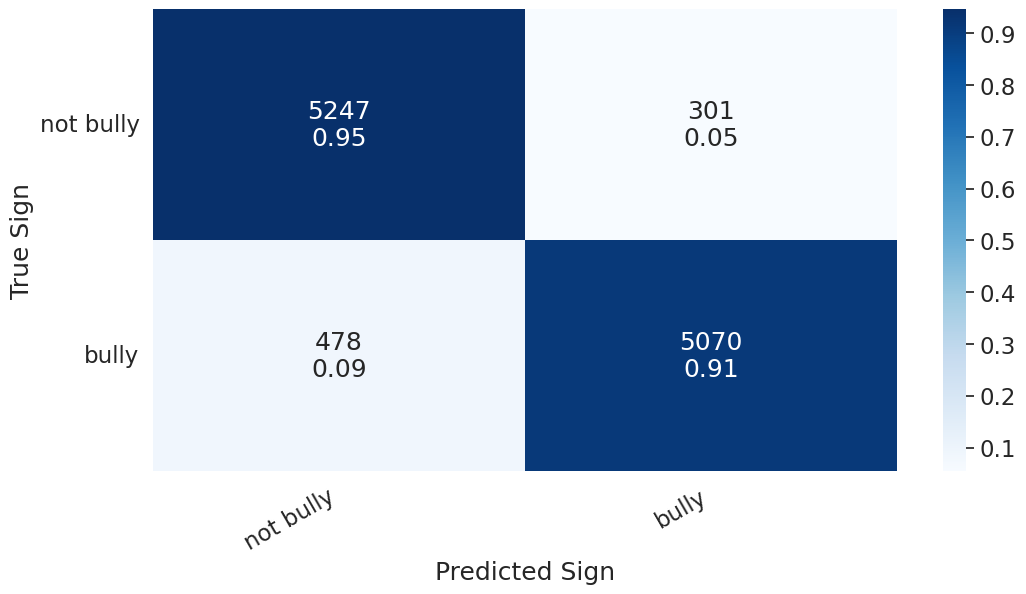

In [83]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)